In [1]:
import pandas as pd



In [2]:
# Veri setini yükle
df = pd.read_excel("CWD.xlsx")

# Kullanılmayacak sütunları silelim
df = df.drop(columns=["Watershed_ID", "X centroid", "Y centrtoid","Recharge","Lithology_Class","Hydrogeological unit","Snow cover area (Km2)","Surface Runoff_avg (m3/s)","Number of faults","Equiped irrigated area (km2)"])

# Kontrol: Kategorik değişken var mı?
print(df.dtypes)

Watershed_Area (Km2)              float64
Karst area (Km2)                  float64
Watertable depth_avg (m)          float64
Precipitation_avg (mm/year)         int64
Eleveation_avg (m.a.s.l)            int64
Slope_avg (°)                     float64
Cropland area (Km2)               float64
Population density (people/km)    float64
Sea-level (m)                     float64
Springs within watershed           object
dtype: object


In [3]:
df["spring_count"] = df["Springs within watershed"].apply(
    lambda x: len(str(x).split(",")) if pd.notna(x) and str(x).strip() != "" else 0
)

In [4]:
def convert_recharge(value):
    if isinstance(value, str):
        if ">" in value:
            return 400
        elif "<" in value:
            return 50
        elif "-" in value:
            parts = value.split("-")
            return (float(parts[0]) + float(parts[1])) / 2
    return pd.to_numeric(value, errors="coerce")


In [5]:
print(df.head())
print(df.columns)
df.head()

   Watershed_Area (Km2)  Karst area (Km2)  Watertable depth_avg (m)  \
0            647.108052          0.000000                      0.00   
1            369.462891        310.348828                      1.97   
2            224.429338          0.000000                      0.93   
3            421.217788          0.000000                      3.44   
4             50.203521          0.000000                      2.83   

   Precipitation_avg (mm/year)  Eleveation_avg (m.a.s.l)  Slope_avg (°)  \
0                         1053                        46            3.1   
1                         1142                        95            4.4   
2                         1119                        73            3.4   
3                         1235                       220           12.9   
4                         1000                        53            4.5   

   Cropland area (Km2)  Population density (people/km)  Sea-level (m)  \
0             0.000000                          3

,Watershed_Area (Km2),Karst area (Km2),Watertable depth_avg (m),Precipitation_avg (mm/year),Eleveation_avg (m.a.s.l),Slope_avg (°),Cropland area (Km2),Population density (people/km),Sea-level (m),Springs within watershed,spring_count
0,647.108052,0.000000,0.00,1053,46,3.1,0.000000,38.339,2.852533,"446, 447, 448, 449, 450, 451",6
1,369.462891,310.348828,1.97,1142,95,4.4,59.114062,19.850,3.922188,"475, 476, 477, 478, 479, 480, 481, 482, 483, 4...",16
2,224.429338,0.000000,0.93,1119,73,3.4,20.198640,5.288,1.293898,NaN,0
3,421.217788,0.000000,3.44,1235,220,12.9,8.424356,5.230,1.293898,"735, 736, 737, 738, 739, 740, 741, 742",8
4,50.203521,0.000000,2.83,1000,53,4.5,5.522387,518.740,3.303307,"168, 169, 170, 171, 172",5


Converting column 'Springs within watershed' to numeric...

Data types after converting to numeric:
Watershed_Area (Km2)              float64
Karst area (Km2)                  float64
Watertable depth_avg (m)          float64
Precipitation_avg (mm/year)         int64
Eleveation_avg (m.a.s.l)            int64
Slope_avg (°)                     float64
Cropland area (Km2)               float64
Population density (people/km)    float64
Sea-level (m)                     float64
Springs within watershed          float64
dtype: object


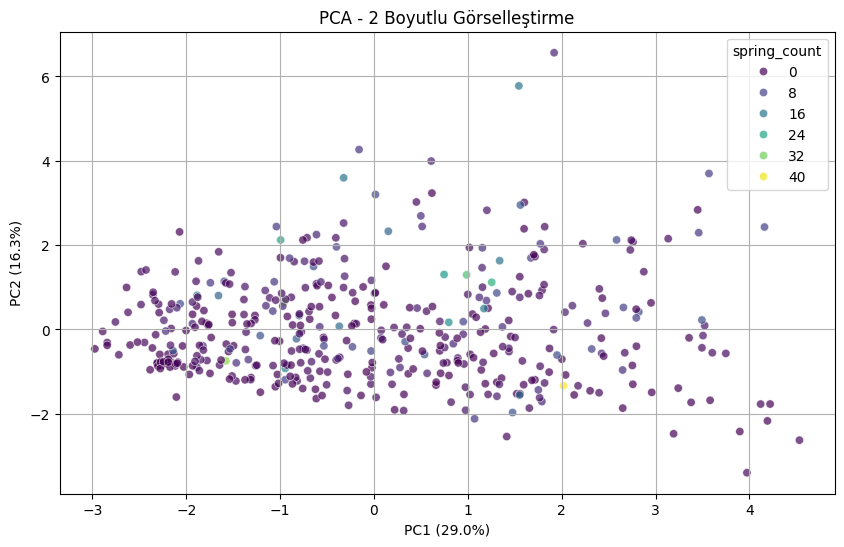

In [6]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer # Import SimpleImputer

# Özellikler (spring_count hariç)
features = df.drop(columns=['spring_count'])

# **DEĞİŞİKLİK BAŞLANGICI**
# İmputer'a beslemeden önce tüm sütunları sayısal türe dönüştürün
# Dönüştürülemeyen değerler NaN olacaktır.
for col in features.columns:
    # Sadece sayısal olmayan türdeki sütunları dönüştürmeye çalışın
    if features[col].dtype == 'object':
         print(f"Converting column '{col}' to numeric...")
         features[col] = pd.to_numeric(features[col], errors='coerce')

# Kontrol için sütun türlerini yazdırın (isteğe bağlı)
print("\nData types after converting to numeric:")
print(features.dtypes)
# **DEĞİŞİKLİK SONU**


# İmputation uygula: NaN değerleri sütunların ortalaması ile doldur
# You can change the strategy to 'median' or 'most_frequent' if needed
imputer = SimpleImputer(strategy='mean')
# Şimdi features DataFrame'ini impute edin, burada NaN değerleri (coerce edilenler dahil) doldurulacaktır.
features_imputed = imputer.fit_transform(features)


# Standardize et (imput edilmiş verilere uygula)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_imputed)

# PCA uygula
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# PCA sonuçlarını dataframe yap
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
# Ensure the index is aligned if rows were dropped, but with imputation it should be fine.
# If using dropna, you would need to handle the index alignment here.
pca_df['spring_count'] = df['spring_count'].reset_index(drop=True)


# PCA görselleştirme
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='spring_count',
    palette='viridis',
    alpha=0.7
)
plt.title("PCA - 2 Boyutlu Görselleştirme")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend(title='spring_count')
plt.grid(True)
plt.show()

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# X ve y
X = df.drop(columns=['spring_count'])
y = df['spring_count']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


Converting column 'Springs within watershed' to numeric before imputation...


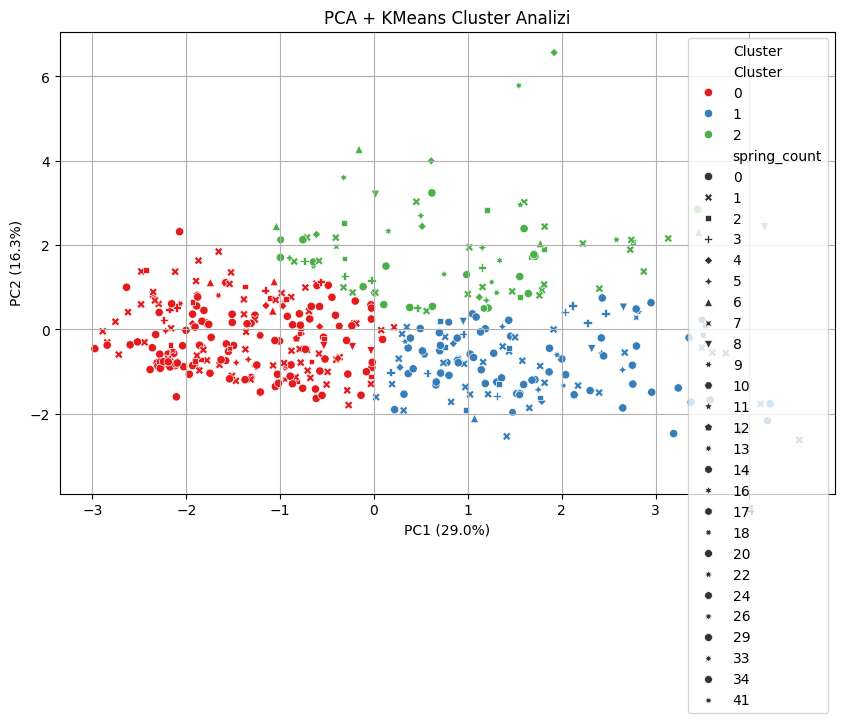

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer # SimpleImputer'ı tekrar import edelim

# Özellikler (spring_count hariç)
X_features = df.drop(columns=['spring_count'])

# İmputer'a beslemeden önce tüm sütunları sayısal türe dönüştürün
# Dönüştürülemeyen değerler NaN olacaktır.
for col in X_features.columns:
    # Sadece sayısal olmayan türdeki sütunları dönüştürmeye çalışın
    if X_features[col].dtype == 'object':
         print(f"Converting column '{col}' to numeric before imputation...")
         X_features[col] = pd.to_numeric(X_features[col], errors='coerce')

# İmputation uygula: NaN değerleri sütunların ortalaması ile doldur
# Bu kısım zaten vardı, buraya tekrar ekleyerek emin oluyoruz ki
# standardize etmeden önce imputation yapılıyor.
imputer = SimpleImputer(strategy='mean')
# Şimdi X_features DataFrame'ini impute edin, burada NaN değerleri (coerce edilenler dahil) doldurulacaktır.
X_features_imputed = imputer.fit_transform(X_features)


# Standardize et (imput edilmiş verilere uygula)
scaler = StandardScaler()
# Standardizasyonu imput edilmiş verilere uygulayın
X_scaled = scaler.fit_transform(X_features_imputed)

# PCA uygula
pca = PCA(n_components=2)
# PCA'yi standardize edilmiş ve imput edilmiş verilere uygulayın
X_pca = pca.fit_transform(X_scaled)

# KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10) # n_init ekleyerek KMeans'in farklı başlangıç noktalarını denemesini sağlarız
clusters = kmeans.fit_predict(X_pca)

# PCA + Cluster sonucu dataframe’e ekle
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters
# Orijinal dataframe'den spring_count'ı alırken index uyumunu kontrol edin
# Imputation ve scaling satır sayısını değiştirmez, bu yüzden index uyumunu korunur.
pca_df['spring_count'] = df['spring_count'].reset_index(drop=True)

# Görselleştir
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='Cluster',
    style='spring_count', # spring_count'a göre farklı markerlar kullan
    palette='Set1'
)
plt.title("PCA + KMeans Cluster Analizi")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

Decision Tree Classifier Performance:
Accuracy: 0.800

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        65
           1       0.73      0.75      0.74        40
           2       0.76      0.64      0.70        25

    accuracy                           0.80       130
   macro avg       0.78      0.76      0.77       130
weighted avg       0.80      0.80      0.80       130


Confusion Matrix:
[[58  4  3]
 [ 8 30  2]
 [ 2  7 16]]


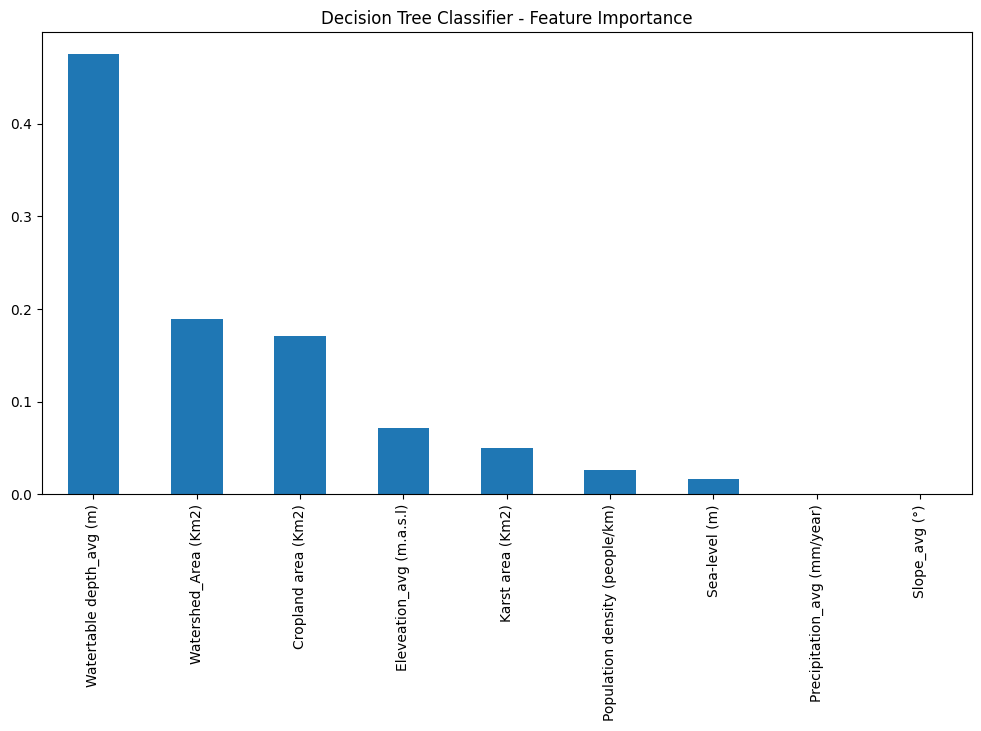

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split # Import train_test_split
import pandas as pd # Import pandas
import matplotlib.pyplot as plt # Import matplotlib for plotting

# Cluster label’ını target olarak kullan
y_cluster = pca_df['Cluster']

# Özellikleri al
# 'spring_count' ve 'Springs within watershed' sütunlarını X'ten çıkarın
X = df.drop(columns=['spring_count', 'Springs within watershed'])

# Train-test split
# Stratify only applies to classification, which this now is with y_cluster
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cluster, test_size=0.3, random_state=42, stratify=y_cluster
)

# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=5,
    random_state=42
)

# Imputation and Scaling (if necessary) - Reapply these steps before training
# Check if there are still non-numeric columns or NaNs in X_train
# If the previous steps successfully converted and imputed, this might not be strictly needed,
# but it's safer to ensure X_train is ready for the classifier.
# Let's re-apply the numeric conversion and imputation to X_train just to be safe.

from sklearn.impute import SimpleImputer # Import SimpleImputer

# Ensure X_train is numeric and handle NaNs
for col in X_train.columns:
    if X_train[col].dtype == 'object':
         print(f"Converting column '{col}' in X_train to numeric...")
         X_train[col] = pd.to_numeric(X_train[col], errors='coerce')

# Impute remaining NaNs in X_train
imputer = SimpleImputer(strategy='mean') # Use the same imputation strategy
# Fit on X_train and transform X_train and X_test
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test) # Use transform only on test set

# Optional: Standardize if needed, but Decision Trees are not sensitive to feature scaling
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_imputed)
# X_test_scaled = scaler.transform(X_test_imputed)


# Decision Tree Classifier'ı train edin (şimdi sayısal veri ile)
dt_classifier.fit(X_train_imputed, y_train) # Use the imputed data

# Tahmin ve performans
y_pred_dt = dt_classifier.predict(X_test_imputed) # Use the imputed data for prediction
acc_dt = accuracy_score(y_test, y_pred_dt)

print("Decision Tree Classifier Performance:")
print(f"Accuracy: {acc_dt:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

# Feature Importance
# Feature importances are based on the columns _after_ dropping 'Springs within watershed'
# and using the imputed array. We need to map the importances back to the original column names.
# The order of features in the imputed array corresponds to the order of columns in X_train before imputation.
importances_dt = pd.Series(dt_classifier.feature_importances_, index=X_train.columns)
importances_dt.sort_values(ascending=False).plot(kind='bar', figsize=(12,6))
plt.title("Decision Tree Classifier - Feature Importance")
plt.show()

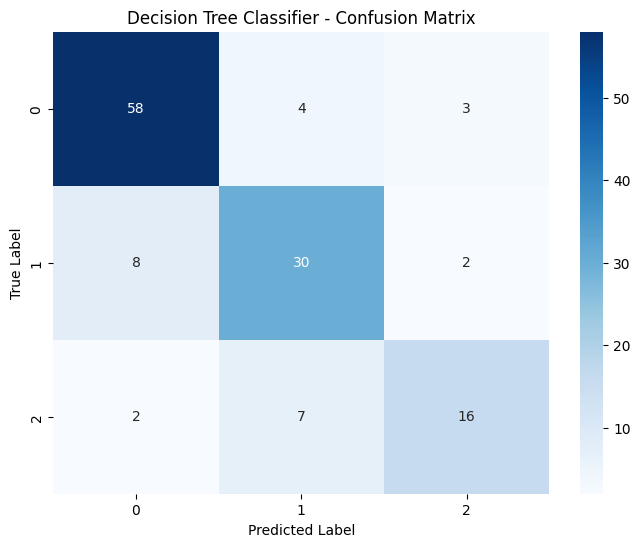

In [10]:
# Karışıklık Matrisini Görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(
    confusion_matrix(y_test, y_pred_dt),
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=dt_classifier.classes_,
    yticklabels=dt_classifier.classes_,
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Decision Tree Classifier - Confusion Matrix')
plt.show()

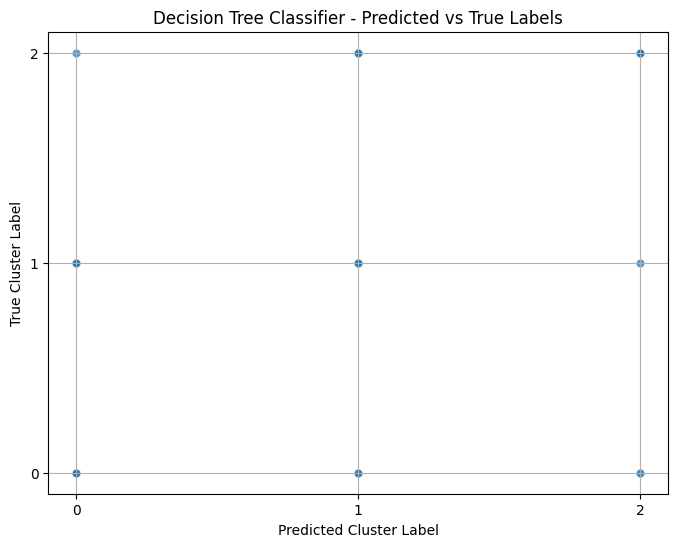

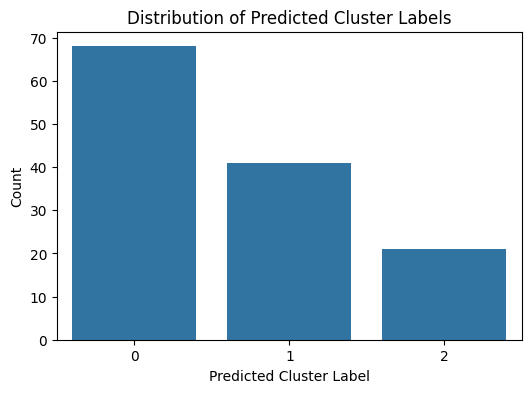

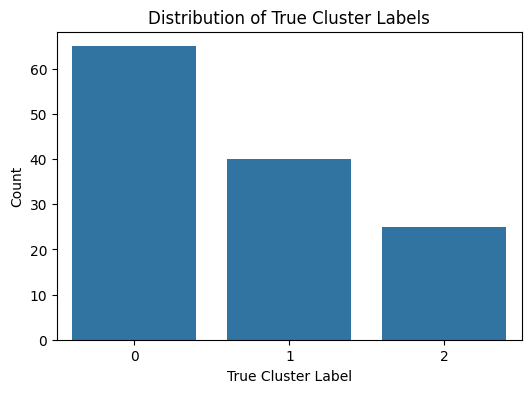

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tahmin edilen etiketleri ve gerçek etiketleri alın
y_true = y_test  # Gerçek etiketler (test setinden)
y_pred = y_pred_dt # Tahmin edilen etiketler (Decision Tree Classifier'dan)

# Tahminler ve gerçek değerlerin dağılımını gösteren bir scatter plot çiz
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=y_true, alpha=0.5)
plt.title('Decision Tree Classifier - Predicted vs True Labels')
plt.xlabel('Predicted Cluster Label')
plt.ylabel('True Cluster Label')
plt.xticks(sorted(y_true.unique())) # X ekseninde benzersiz etiketleri göster
plt.yticks(sorted(y_true.unique())) # Y ekseninde benzersiz etiketleri göster
plt.grid(True)
plt.show()

# İsteğe bağlı: Etiketlerin sayısını gösteren bir countplot da faydalı olabilir
# Tahmin edilen etiketlerin dağılımı
plt.figure(figsize=(6, 4))
sns.countplot(x=y_pred)
plt.title('Distribution of Predicted Cluster Labels')
plt.xlabel('Predicted Cluster Label')
plt.ylabel('Count')
plt.show()

# Gerçek etiketlerin dağılımı
plt.figure(figsize=(6, 4))
sns.countplot(x=y_true)
plt.title('Distribution of True Cluster Labels')
plt.xlabel('True Cluster Label')
plt.ylabel('Count')
plt.show()